In [ ]:
# Run CPU-only, GPU code needs further testing
"""
Restart kernel after running
Only need to run once
"""
!pip install scikit-learn matplotlib seaborn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import torch
import torch.utils.data as td
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
import wandb


froot = './data/k562_samp_epft_norm_test_1.csv'

df = pd.read_csv(froot)

/grid/it/data/elzar/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/grid/siepel/home_norepl/hassett/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
print(df.head())

  seqnames     start       end strand  ensembl_gene_id  score      ctcf  \
0       15  88623545  88623545      +  ENSG00000181026    0.0 -0.079992   
1       15  88623546  88623546      +  ENSG00000181026    0.0 -0.079942   
2       15  88623547  88623547      +  ENSG00000181026    0.0 -0.079893   
3       15  88623548  88623548      +  ENSG00000181026    0.0 -0.079844   
4       15  88623549  88623549      +  ENSG00000181026    0.0 -0.079796   

   h3k36me3   h3k4me1  h3k79me2   h3k9me1   h3k9me3  h4k20me1       sj5  \
0 -0.000099  0.348531  4.423451  0.446508 -0.168099  3.232475 -0.028916   
1  0.001638  0.352677  4.460072  0.453024 -0.169218  3.259194 -0.028916   
2  0.003360  0.356807  4.496664  0.459491 -0.170339  3.285849 -0.028916   
3  0.005065  0.360919  4.533223  0.465908 -0.171461  3.312435 -0.028916   
4  0.006754  0.365013  4.569743  0.472274 -0.172584  3.338952 -0.028916   

        sj3       dms  wgbs      rpts  lambda_alphaj      zeta  
0 -0.057178 -0.307549   0.0  0.24

In [3]:
column_names = np.array(df.columns)
feature_names = column_names[6:-2]
num_features = len(feature_names)
#nucleotides = column_names[-6:-2]
print(feature_names)
#print(nucleotides)
num_samples = df.shape[0]

# process read counts
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

['ctcf' 'h3k36me3' 'h3k4me1' 'h3k79me2' 'h3k9me1' 'h3k9me3' 'h4k20me1'
 'sj5' 'sj3' 'dms' 'wgbs' 'rpts']


In [4]:
print("Number of Samples: " + str(num_samples))

Number of Samples: 16182613


In [5]:
print("Number of Features: " + str(num_features))

Number of Features: 12


In [6]:
#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-2].values
Y_ji_shape = Y_ji.shape
print(Y_ji.shape)

(16182613, 12)


In [7]:
C_j = df['lambda_alphaj'].values

In [8]:
gene_ids = df['ensembl_gene_id'].values

In [9]:
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

CUDA (GPU support) is available: False
Number of GPUs available: 0


In [10]:
class GeneDataset(Dataset):
    def __init__(self, GeneId, Y_ji, X_ji, C_j, Z_ji):
        self.GeneId = GeneId
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        # Only count full batches
        return len(self.Y_ji) // 100

    def __getitem__(self, idx):
        batch_start = idx * 100
        batch_end = batch_start + 100

        data = {
            #'GeneId':  self.GeneId[batch_start:batch_end], # Uncomment if needed
            'Y_ji':  torch.tensor(self.Y_ji[batch_start:batch_end], dtype=torch.float64),
            'X_ji': torch.tensor(self.X_ji[batch_start:batch_end], dtype=torch.float64),
            'C_j': torch.tensor(self.C_j[batch_start:batch_end], dtype=torch.float64),
            'Z_ji': torch.tensor(self.Z_ji[batch_start:batch_end], dtype=torch.float64)
        }
        return data

In [63]:
from sklearn.model_selection import train_test_split

train_gene_ids, test_gene_ids, train_Y_ji, test_Y_ji, train_X_ji, test_X_ji, train_C_j, test_C_j, train_Z_ji, test_Z_ji = train_test_split(gene_ids, Y_ji, X_ji, C_j, Z_ji, test_size=0.2, shuffle=False)

# Create dataset instances for train and test
train_dataset = GeneDataset(train_gene_ids, train_Y_ji, train_X_ji, train_C_j, train_Z_ji)
test_dataset = GeneDataset(test_gene_ids, test_Y_ji, test_X_ji, test_C_j, test_Z_ji)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [65]:
print("train data size: " + str(len(train_dataset)))

train data size: 129460


In [66]:
print("train # genes: " + str(len(set(train_dataset.GeneId))))

train # genes: 447


In [67]:
def build_dataset(train_data, batch_size):
    loader = DataLoader(train_data, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
    return loader

In [76]:
import math 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Sequential()

# DeepChrome Model
# stage 1: filter bank -> squashing -> Max pooling
model.add_module('temp_conv1', nn.Conv1d(12, 50, 10))
#model.add_module('relu1', nn.ReLU())
#model.add_module('temp_maxpool1', nn.MaxPool1d(5))

# stage 2: standard 2-layer neural network
model.add_module('view', nn.Flatten())  # Replaces nn.View
#model.add_module('dropout', nn.Dropout(0.2))
#model.add_module('linear1', nn.Linear(math.ceil((100-10)/5)*50, 625))
#model.add_module('relu2', nn.ReLU())
model.add_module('linear2', nn.Linear(4550, 100))

#model.add_module('relu3', nn.ReLU())
#model.add_module('linear3', nn.Linear(125, 100))


if cuda_available:
    """
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    """
    model = model.to('cuda')

print(model)

arr = torch.randn((10,num_features,100)).to(device)
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)
model.double()

Sequential(
  (temp_conv1): Conv1d(12, 50, kernel_size=(10,), stride=(1,))
  (view): Flatten(start_dim=1, end_dim=-1)
  (linear2): Linear(in_features=4550, out_features=100, bias=True)
)
torch.Size([10, 100])
Number of parameters: 461150
Model is on device: cpu


Sequential(
  (temp_conv1): Conv1d(12, 50, kernel_size=(10,), stride=(1,))
  (view): Flatten(start_dim=1, end_dim=-1)
  (linear2): Linear(in_features=4550, out_features=100, bias=True)
)

In [77]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        C_j_value = C_j[0]
        X_ji = X_ji.squeeze(0)
        rho_ji = rho_ji.squeeze(0)
        loss = X_ji * rho_ji + C_j_value * torch.exp(-rho_ji) - X_ji * torch.log(C_j_value)
        return (loss).mean()

In [78]:
"""
with torch.no_grad():
    for param in model.parameters():
        param.zero_()
"""

'\nwith torch.no_grad():\n    for param in model.parameters():\n        param.zero_()\n'

In [79]:
def build_optimizer(network, optimizer, learning_rate, momentum):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=momentum)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

In [80]:
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    print(len(loader))
    total_loss = 0
    for idx, batch in enumerate(loader):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device)
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    return avg_loss

In [ ]:
def print_profiler_results(profiler):
    print(profiler.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

loader = build_dataset(train_dataset, 1)#16000000)
optimizer = build_optimizer(model, "adam", 1e-7, 0)
loss_fn = CustomLoss()

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
    on_trace_ready=print_profiler_results,
    record_shapes=True,
    profile_memory=True
) as profiler:
    for epoch in range(10):
        print(f'Epoch {epoch+1}')
        model.train()
        print(len(loader))
        total_loss = 0
        for idx, batch in enumerate(loader):
            optimizer.zero_grad()
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch.permute(0,2,1))
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            #profiler.step()
        avg_loss = total_loss / len(loader)
        print(avg_loss)

Epoch 1
129460
0.09978827660860778
Epoch 2
129460
0.09829182425718455
Epoch 3
129460


In [ ]:
train()

In [ ]:
from datetime import datetime
"""
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"models/Elongation_Linear_Model.pth"
torch.save(model.state_dict(), filename)
"""

In [ ]:
model = nn.Linear(num_features, 1, bias=False)
model.load_state_dict(torch.load("models/Elongation_Linear_Model.pth"))
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    """
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    """
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)
model.double()

In [ ]:
weights = model.weight.data.cpu().numpy()
#bias = model.bias.data.cpu().numpy()

combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

#print("bias: " + str(model.bias.data))

In [ ]:
glm_kappa = [-0.0224536145637661, -0.094592589, -0.023815382, 0.030402922, -0.067234092, -0.032196914, -0.040911478, -0.018557168, -0.033545905, -0.051103287, -0.204434712, 0.015831043]

In [ ]:
"""
GLM K

* ctcf: -0.02
* h3k36me3: -0.09
* h3k4me1: -0.02
* h3k79me2: +0.03
* h3k9me1: -0.06
* h3k9me3: -0.03
* h4k20me1: -0.04
* sj5: -0.02
* sj3: -0.03
* dms->stem-loop: -0.05
* rpts->low-complex: +0.01
* wgbs->DNAm: -0.2
"""

In [ ]:
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

torch.Size([100])
torch.Size([100])


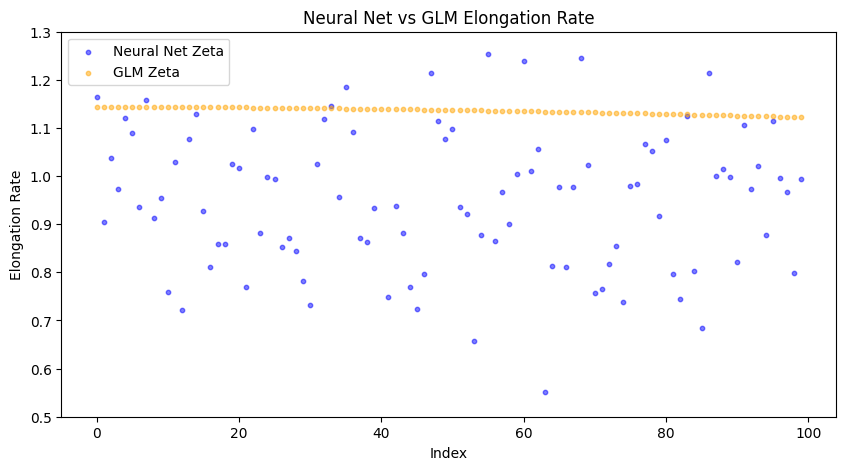

In [75]:
model.eval()
test_iter = iter(test_loader)
batch1 = next(test_iter)
with torch.no_grad():
    y_inputs = batch1['Y_ji']
    rho_ji = model(y_inputs.permute(0,2,1))
    plot_data(batch1['Z_ji'][0], torch.exp(rho_ji)[0])

In [58]:
def plot_data(glm_zeta, net_zeta):
    print(glm_zeta.size())
    print(net_zeta.size())
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.scatter(indices, net_zeta, color='blue', label='Neural Net Zeta', s=10, alpha=0.5)
    ax.scatter(indices, glm_zeta, color='orange', label='GLM Zeta', s=10, alpha=0.5)
    
    ax.set_title('Neural Net vs GLM Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()
    
    plt.ylim(0.5, 1.3)

    plt.show()


In [ ]:
test_batches = create_batches(test_data.groupby('GeneId'), max_batch_size=64)

test_dataset = GeneDataset(test_batches)
tstdl = DataLoader(test_dataset, batch_size=1)

In [ ]:
net_zeta = []
glm_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        # convert log(Z) outputs to Z
        net_zeta.append(torch.exp(rho_ji.cpu()[0]))
        glm_zeta.append(batch['Z_ji'][0])

net_zeta = torch.cat(net_zeta, dim=0)
glm_zeta = torch.cat(glm_zeta, dim=0)
mae = F.l1_loss(net_zeta.squeeze(), glm_zeta)
mse = F.mse_loss(net_zeta.squeeze(), glm_zeta)

correlation_coefficient = np.corrcoef(glm_zeta, net_zeta.squeeze())[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

In [ ]:
def density_plot(glm_zeta, net_zeta, gene_id):
    sns.kdeplot(x=glm_zeta, y=net_zeta, fill=True, cmap="Blues")
            
    plt.xlim([min(glm_zeta), max(glm_zeta)])
    plt.ylim([min(net_zeta), max(net_zeta)])


    plt.xlabel('GLM Elongation Rate')
    plt.ylabel('Neural Net Elongation Rate')
    plt.title(gene_id)
    plt.show()

In [ ]:
def scatterplot(net_zeta, glm_zeta, gene_id):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    min_val = min(min(net_zeta), min(glm_zeta))
    max_val = max(max(net_zeta), max(glm_zeta))

    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    
    ax.scatter(net_zeta, glm_zeta, s=5)
    
    ax.set_title(gene_id)
    ax.set_xlabel('Neural Net Zeta')
    ax.set_ylabel('GLM Zeta')
    ax.legend()

    plt.show()


In [ ]:
test_batches2 = create_batches(test_data.groupby('GeneId'), max_batch_size=2000)

test_dataset2 = GeneDataset(test_batches2)
tstdl2 = DataLoader(test_dataset2, batch_size=1)

In [ ]:
total_loss = 0
loss_fn = CustomLoss()
for batch in tstdl2:
    gene_id = batch['GeneId'][0]
    model.eval()
    #print("number of samples: " + str(len(batch)))

    with torch.no_grad():
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
    
    glm_zeta = batch['Z_ji'][0]
    # convert log(Z) outputs to Z
    net_zeta = torch.exp(rho_ji.cpu().squeeze())
        
    density_plot(glm_zeta, net_zeta, gene_id)
                
    plot_data(glm_zeta, net_zeta)

In [ ]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=glm_kappa, y=weights[0])

for i in range(len(glm_kappa)):
    plt.text(glm_kappa[i], weights[0][i], feature_names[i], fontsize=13, ha='right', va='top')
plt.xlabel('GLM Weights')
plt.ylabel('Neural Net Weights')

max_val = max(np.max(glm_kappa), np.max(weights[0])) + 0.04
min_val = min(np.min(glm_kappa), np.min(weights[0])) - 0.04

plt.xlim(max_val, min_val)
plt.ylim(max_val, min_val)

# Show the plot
plt.show()

In [ ]:
# profiling code
"""
def print_profiler_results(profiler):
    print(profiler.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
    on_trace_ready=print_profiler_results,
    record_shapes=True,
    profile_memory=True
) as profiler:

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}')
        model.train()
        trndl = DataLoader(train_set, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
        for i, batch in enumerate(trndl):
            optimizer.zero_grad()
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
            profiler.step()
        loss_hist_train[epoch] /= len(trndl)
        del trndl
"""

In [ ]:
# sparse loss function
"""
def sparse_dense_mul(s, d):
    i = s._indices()
    v = s._values()
    dv = d[i.squeeze()]
    return torch.sparse.FloatTensor(i, v * dv, s.size())

def sparse_dense_add(s, d):
    s = s.to(d.device)

    indices = s._indices()
    if indices.dim() == 1:
        indices = indices.squeeze()
    values = s._values()

    d[indices] += values

    return d

class SparseCustomLoss(nn.Module):
    def __init__(self):
        super(SparseCustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        C_j_value = C_j[0]
        X_ji = X_ji.squeeze(0)
        rho_ji = rho_ji.squeeze(0).squeeze(1)
        #X_ji_sparse = X_ji.to_sparse()
        #term1 = sparse_dense_mul(X_ji_sparse, rho_ji)
        #term2 = C_j_value * torch.exp(-rho_ji)
        #loss = sparse_dense_add(term1, term2)
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji)
        return (loss).mean()
"""